# Forecasting_Backorders_In_Inventory

1. Backorders are unavoidable, but by anticipating which things will be backordered, planning can be streamlined at several  levels, preventing unexpected strain on production, logistics, and transportation.

2. ERP systems generate a lot of data (mainly structured) and also contain a lot of historical data. If this data can be properly utilized, a predictive model to forecast backorders and plan accordingly can be constructed. 

3. Based on past data from inventories, supply chain and sales, we can classify the products as going into backorder or not.

### what is backorder ?

Backorder is an order which can’t be fulfilled at the given time due to lack of supply or the product is currently out of stock or not in inventory but can guarantee delivery of the goods or service requested by a certain date in the future because the production of goods or replenishment of inventory is underway. Unlike in the situation of Out-of-stock where the delivery date of the goods can’t be promised , in the Backorder scenario the customers are allowed to shop for the products and order. Simply put Backorder can be thought of as an order with a delayed delivery date.

### Dataset Discription

1. sku (stock keeping unit) : Unique Product Id for each item
2. national_inv : Current inventory level of component
3. lead_time : Transit time of the product which means how long it takes for a shipment to be delivered at its final destination after it has been picked from the start point.
4. in_transit_qty : Amount of products in transit or moving from source to inventory.
> forecast_X_month : Forecast of sales of the product for coming X months respectively 
5. forecast_3_month
6. forecast_6_month
7. forecast_9_month
> sales_X_month : Actual sales of the product for prior X months respectively 
8. sales_1_month
9. sales_3_month
10. sales_6_month
11. sales_9_month
12. min_bank : Minimum amount of stocks recommended for a product.
13. potential_issue : Indictor variable noting potential issue with item i.e, Any problem identified in the product/part
14. pieces_past_due : Amount of parts of the product overdue if any.
> perf_X_month_avg: Product performance over past 6 months and 12 months respectively.
15. perf_6_month_avg
16. perf_12_month_avg
17. local_bo_qty : Amount of stock orders overdue 
> General Risk Flags (Yes or No) set for the products
18. deck_risk
19. oe_constraint
20. ppap_risk
21. stop_auto_buy
22. rev_stop
23. went_on_backorder : Target variable with (Yer or No) saying product went for backorder or not 

In [1]:
import os
# os.chdir('..')

In [2]:
os.getcwdb()

b'd:\\VS_projects\\Forecasting-Backorders-In-Inventory\\notebook'

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import fbeta_score, precision_score, roc_auc_score,accuracy_score, recall_score, confusion_matrix,roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from prettytable import PrettyTable
from tqdm import tqdm

ModuleNotFoundError: No module named 'prettytable'

# Exploring the Data

In [4]:
df = pd.read_csv("backorders_data.csv")
pd.set_option('display.max_columns', None)


/tmp/ipykernel_307/610895356.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("backorders_data.csv")


In [5]:
df.drop(columns=["Unnamed: 0"],inplace= True)

In [6]:
df

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929932,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
1929933,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
1929934,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
1929935,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,88.0,4.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No


## No.of rows & columns

In [7]:
def get_total_rows_and_columns(df):
    total_rows = df.shape[0]
    total_cols = df.shape[1]
    print(f"the dataframe is having {total_rows} rows and {total_cols} columns")
get_total_rows_and_columns(df)

the dataframe is having 1929937 rows and 23 columns


## Checking Target class is balanced or not

In [8]:
df["went_on_backorder"].value_counts()

No     1915954
Yes      13981
Name: went_on_backorder, dtype: int64

<AxesSubplot: ylabel='went_on_backorder'>

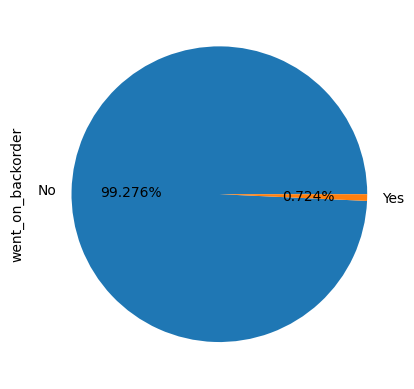

In [9]:
df["went_on_backorder"].value_counts().plot(kind="pie", autopct = '%.3f%%')

##### 1. here we can observe that the target column "went_on_backorder" is highly imbalanced
##### 2. The percentage data with went_on_backorder = yes is just 0.72%
##### 3. This imbalanced data need to be handled further


## Statistical information about the numerical cols

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,1929935.0,496.568259,29573.434344,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1814318.0,7.878627,7.054212,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1929935.0,43.064397,1295.420493,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1929935.0,178.539864,5108.770174,0.0,0.00,0.00,4.00,1510592.0
forecast_6_month,1929935.0,345.465893,9831.562085,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1929935.0,506.606748,14345.430866,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1929935.0,55.368164,1884.377009,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1929935.0,174.663858,5188.855852,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1929935.0,341.565349,9585.030376,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1929935.0,523.577094,14733.265629,0.0,0.00,4.00,47.00,3205172.0



##### 1. here from the count of each column we can observe that every column except the lead_time are having 2 missing values and lead_time is having more missing values

##### 2. And for most of the features, the 75 percentile values are less than their mean values which indicates that those features distribution are right skewed.

##### 3. Also the difference b/w the 75th percentile value and max value is very high which indicates that there is precence of the outliers

##### 4. The values of all the features are not on the same scale. So,we need to apply scaling on these features 

##### 5. This need to handled while preprocessing of the data


## Statistical information about the Categorical cols

In [11]:
df.describe(include="O").T

,count,unique,top,freq
sku,1929937,1929937,1026827,1
potential_issue,1929935,2,No,1928946
deck_risk,1929935,2,No,1494482
oe_constraint,1929935,2,No,1929643
ppap_risk,1929935,2,No,1697383
stop_auto_buy,1929935,2,Yes,1859391
rev_stop,1929935,2,No,1929096
went_on_backorder,1929935,2,No,1915954


##### 1. The sku feature represents the product id, so it is unique value for every product
##### 2. This feature dont help for prediction of backorder or not. so we can drop this feature
##### 3. the oe_constraint,rev_stop,potential_issue are having "No" values of 19,29,643 , 19,29,096, 1928946 respectively i.e nearly equal to total data points 19,29,937
##### 4. all other categorical features are having only 2 unique categories.

## dropping the "sku" feature

In [12]:
df.drop(columns=["sku"], inplace= True)
df.head(3)

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


## Checking Missing values 

In [13]:
def check_missing_values(df):
    for col in df.columns:
        missing_values = df[col].isna().sum()
        missing_perc = np.round(missing_values*100/df.shape[0], 6)
        print(f"{col} is having {missing_values} missing values i.e ---> {missing_perc}")

check_missing_values(df)

national_inv is having 2 missing values i.e ---> 0.000104
lead_time is having 115619 missing values i.e ---> 5.990817
in_transit_qty is having 2 missing values i.e ---> 0.000104
forecast_3_month is having 2 missing values i.e ---> 0.000104
forecast_6_month is having 2 missing values i.e ---> 0.000104
forecast_9_month is having 2 missing values i.e ---> 0.000104
sales_1_month is having 2 missing values i.e ---> 0.000104
sales_3_month is having 2 missing values i.e ---> 0.000104
sales_6_month is having 2 missing values i.e ---> 0.000104
sales_9_month is having 2 missing values i.e ---> 0.000104
min_bank is having 2 missing values i.e ---> 0.000104
potential_issue is having 2 missing values i.e ---> 0.000104
pieces_past_due is having 2 missing values i.e ---> 0.000104
perf_6_month_avg is having 2 missing values i.e ---> 0.000104
perf_12_month_avg is having 2 missing values i.e ---> 0.000104
local_bo_qty is having 2 missing values i.e ---> 0.000104
deck_risk is having 2 missing values i.e 

##### 1. Here we can observe that the feature "lead_time" having the 5.99% null values i.e, 115619  values 

### dropping the rows which are having all the column values as Nan

In [14]:
all_cols = df.columns
df.drop(index=df[df[all_cols].isna().all(1)].index, inplace= True)

In [15]:
df[df[all_cols].isna().all(1)]

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder


### Checking the duplicated values

In [16]:
df.duplicated().sum()

793769

*There are 793769 rows which have the exact same values as another row from the data, these rows can be considered as duplicates. All these duplicated rows will be dropped considering train time complexity and also training a ML model on repeated data will not contribute much information to the loss.*

In [17]:
df.drop_duplicates(inplace=True)
df.shape

(1136166, 22)

No     1123244
Yes      12922
Name: went_on_backorder, dtype: int64


<AxesSubplot: ylabel='went_on_backorder'>

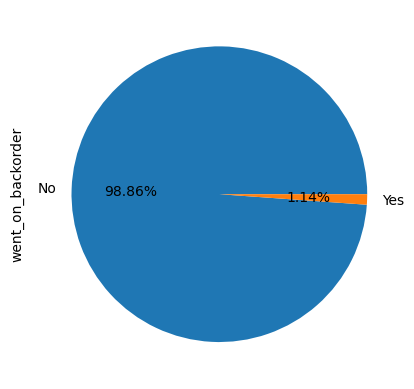

In [18]:
##checing the target column's class ratios
print(df["went_on_backorder"].value_counts())
df["went_on_backorder"].value_counts().plot(kind="pie",autopct= "%.2f%%")

## Rechecking the numerical feature statistical info

In [19]:
np.round(df.describe().T,4)

,count,mean,std,min,25%,50%,75%,max
national_inv,1136166.0,743.9231,38186.6538,-27256.0,9.00,38.00,159.00,12334404.0
lead_time,1090172.0,7.7032,7.1615,0.0,4.00,8.00,8.00,52.0
in_transit_qty,1136166.0,72.9145,1687.6606,0.0,0.00,0.00,4.00,489408.0
forecast_3_month,1136166.0,300.9322,6654.9058,0.0,0.00,0.00,30.00,1510592.0
forecast_6_month,1136166.0,583.8550,12807.7527,0.0,0.00,2.00,69.00,2461360.0
forecast_9_month,1136166.0,857.1469,18688.2248,0.0,0.00,6.00,108.00,3777304.0
sales_1_month,1136166.0,93.9293,2455.1017,0.0,0.00,2.00,16.00,741774.0
sales_3_month,1136166.0,296.3053,6760.0193,0.0,1.00,9.00,53.00,1105478.0
sales_6_month,1136166.0,579.3363,12486.7671,0.0,3.00,19.00,109.00,2146625.0
sales_9_month,1136166.0,887.9740,19193.5879,0.0,5.00,28.00,166.00,3205172.0


> *The minimum value of current inventory level of products is -27256, so this indicates that there are negative inventories in the data. Having negative inventories is a useful information because typically backorders tend to have negative inventory, so this will be helpful in classifying Backorders .*

> *Some products have been given -ve values as performance score, apart from the negative values by looking at the percentile values of the performance scores, 25%le is 0.72 and 100%le value is 1 which could indicate that features have been given scores between 0 to 1.*

> *There are 50% of products that doesn't have any forecast sales in the first 3 months, if the forecast is accurate then most of the products might have very few sales or no sales at all in the first 3 months. If there are no sales then there won't be any backorders.*

> *Features 'pieces_past_due' and 'local_bo_qty' have only 0's as values till 75%le, checking all the percentile values will help determine whether the features are important or not.*



## outlier percentage using IQR method

In [20]:
def detect_outlierpercentage(x):
    data = df[[x]]
    q1 = data[x].quantile(.25)
    q3 =data[x].quantile(.75)

    iqr = q3 - q1

    lb = q1 - 1.5*iqr
    ub = q3 + 1.5*iqr
    # print(q1, q3, iqr, lb, ub) 
    no_of_outliers = data[(data[x]> ub) | (data[x]<lb)].shape[0]
    outliers_perc = (no_of_outliers/data.shape[0])* 100
    return np.round(outliers_perc,2)


In [21]:
num_cols = [i for i in df.columns if df[i].dtype != "O"]
for col in num_cols:
    outlier_percentage = detect_outlierpercentage(col)
    print(f"outlier_per for {col} is : {outlier_percentage}%")


outlier_per for national_inv is : 14.05%
outlier_per for lead_time is : 3.16%
outlier_per for in_transit_qty is : 19.16%
outlier_per for forecast_3_month is : 17.32%
outlier_per for forecast_6_month is : 16.87%
outlier_per for forecast_9_month is : 16.54%
outlier_per for sales_1_month is : 15.41%
outlier_per for sales_3_month is : 15.66%
outlier_per for sales_6_month is : 15.65%
outlier_per for sales_9_month is : 15.66%
outlier_per for min_bank is : 14.08%
outlier_per for pieces_past_due is : 2.28%
outlier_per for perf_6_month_avg is : 10.87%
outlier_per for perf_12_month_avg is : 9.88%
outlier_per for local_bo_qty is : 2.25%


### Note:
##### 1. since what we came to know from the numerical statiscal analysis above, most of the feature are following the positive skewness
##### 2. This is not because of presence of outliers always. Because, take a simple scenario like below:
            a) Think of a case where the sales of a product is high since last 12 months. 
            Due to this the forecast sales of the product will also be high for next 3,6,9 months.
            Also, due to forecast and sales are high for the product the inventory and intransit quantity will also be high for that product
            
            b) the sales of one product can be very high when compared to other products. 
            so there will be huge spike in the sales can cause skewness in distribution of sales.
##### 3. So, considering the positive skewness present in the data, they may not be because of the outliers.
##### 4. also, the we can say the above outlier percentage can also be containing the natural outlier data points representing the product sales for a particular season or period of time 

## Distribution of all the numerical features

array([[<AxesSubplot: title={'center': 'national_inv'}>,
        <AxesSubplot: title={'center': 'lead_time'}>,
        <AxesSubplot: title={'center': 'in_transit_qty'}>,
        <AxesSubplot: title={'center': 'forecast_3_month'}>],
       [<AxesSubplot: title={'center': 'forecast_6_month'}>,
        <AxesSubplot: title={'center': 'forecast_9_month'}>,
        <AxesSubplot: title={'center': 'sales_1_month'}>,
        <AxesSubplot: title={'center': 'sales_3_month'}>],
       [<AxesSubplot: title={'center': 'sales_6_month'}>,
        <AxesSubplot: title={'center': 'sales_9_month'}>,
        <AxesSubplot: title={'center': 'min_bank'}>,
        <AxesSubplot: title={'center': 'pieces_past_due'}>],
       [<AxesSubplot: title={'center': 'perf_6_month_avg'}>,
        <AxesSubplot: title={'center': 'perf_12_month_avg'}>,
        <AxesSubplot: title={'center': 'local_bo_qty'}>, <AxesSubplot: >]],
      dtype=object)

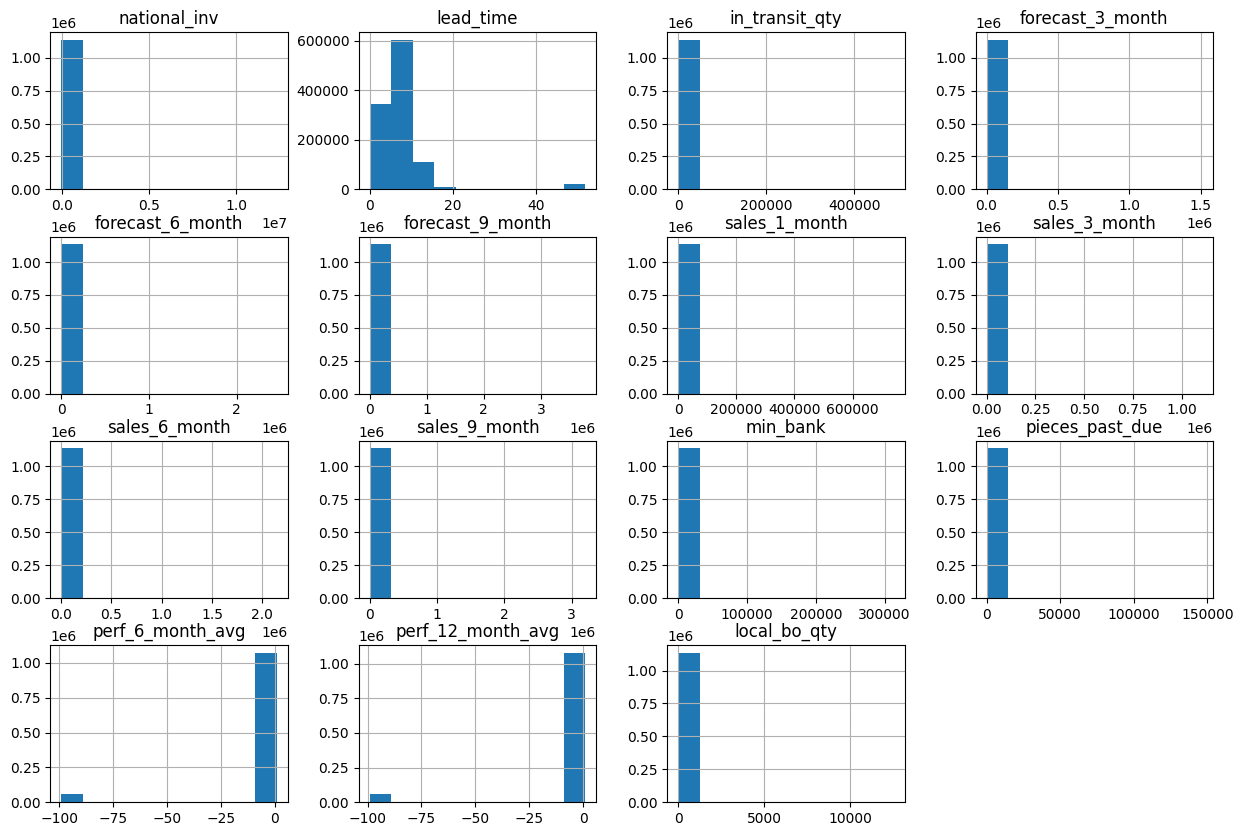

In [22]:
df.hist(figsize=(15,10))

### 1. here since the spread of the data of all the features are very huge , we are unable to get the insights from the distributions above

#### Percentile values for all the num cols

In [23]:
def get_percentile_values(df):
    num_cols = [col for col in df.columns if df[col].dtype != "O"]
    df1 = pd.DataFrame()
    for col in num_cols:

        percentile_dict = dict()
        percentile_dict["col_name"] = col
        for i in range(0,101, 10):
            percentile_dict[f"{i}_th"] = [df[col].quantile(i/100)]
        for k in range(91,101):
            percentile_dict[f"{k}_th"] = [df[col].quantile(k/100)]
        for l in np.arange(0.0, 1.1 ,0.1):
            percentile_dict[f"{99+(l)}_th"] = [df[col].quantile(0.99+(l/100))]
        df2 =  pd.DataFrame(percentile_dict)
        df1 = pd.concat([df1, df2], ignore_index=True)
    return df1

In [24]:
percentiles_df = get_percentile_values(df)

In [25]:
percentiles_df

,col_name,0_th,10_th,20_th,30_th,40_th,50_th,60_th,70_th,80_th,90_th,100_th,91_th,92_th,93_th,94_th,95_th,96_th,97_th,98_th,99_th,99.0_th,99.1_th,99.2_th,99.3_th,99.4_th,99.5_th,99.6_th,99.7_th,99.8_th,99.9_th,100.0_th
0,national_inv,-27256.0,3.00,6.00,12.00,20.00,38.00,66.00,115.00,228.00,605.00,12334404.0,702.00,822.00,975.00,1181.00,1504.00,2000.00,2840.0,4482.0,8382.35,8382.35,9331.03,10417.36,11829.845,13654.05,15929.175,19477.02,24725.505,34869.70,58726.455,12334404.0
1,lead_time,0.0,2.00,2.00,4.00,8.00,8.00,8.00,8.00,8.00,12.00,52.0,12.00,12.00,12.00,12.00,12.00,13.00,16.0,30.0,52.00,52.00,52.00,52.00,52.000,52.00,52.000,52.00,52.000,52.00,52.000,52.0
2,in_transit_qty,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,9.00,49.00,489408.0,60.00,73.00,90.00,113.00,149.00,201.00,290.0,472.0,1000.00,1000.00,1114.00,1270.68,1461.000,1722.01,2077.000,2577.00,3375.000,4800.00,8463.835,489408.0
3,forecast_3_month,0.0,0.00,0.00,0.00,0.00,0.00,4.00,16.00,53.00,225.00,1510592.0,268.00,323.00,400.00,500.00,640.00,864.00,1200.0,1931.0,3900.00,3900.00,4275.00,4888.00,5550.000,6528.00,8000.000,9960.00,13000.000,19133.34,35640.000,1510592.0
4,forecast_6_month,0.0,0.00,0.00,0.00,0.00,2.00,13.00,40.00,119.00,455.00,2461360.0,536.00,640.00,799.00,1000.00,1240.00,1649.00,2310.0,3630.0,7339.35,7339.35,8064.00,9220.68,10583.690,12528.00,15369.525,19180.00,25000.000,35220.67,67561.790,2461360.0
5,forecast_9_month,0.0,0.00,0.00,0.00,0.00,6.00,23.00,66.00,184.00,680.00,3777304.0,801.00,968.00,1173.00,1458.00,1850.00,2409.00,3420.0,5359.0,10800.00,10800.00,11952.00,13560.00,15680.000,18600.00,22677.525,28000.00,36247.575,51232.06,98880.000,3777304.0
6,sales_1_month,0.0,0.00,0.00,0.00,1.00,2.00,5.00,10.00,25.00,83.00,741774.0,97.00,116.00,140.00,172.00,216.00,281.00,385.0,590.0,1122.00,1122.00,1232.00,1372.00,1570.000,1836.00,2217.000,2730.00,3516.000,5014.34,9409.845,741774.0
7,sales_3_month,0.0,0.00,1.00,2.00,5.00,9.00,17.00,35.00,83.00,274.00,1105478.0,320.00,381.00,459.00,563.00,703.00,909.00,1240.0,1902.0,3629.00,3629.00,4035.00,4523.00,5118.000,5964.04,7087.175,8744.00,11261.505,15633.68,28177.050,1105478.0
8,sales_6_month,0.0,0.00,2.00,5.00,10.00,19.00,36.00,73.00,170.00,550.00,2146625.0,641.00,762.00,917.00,1117.00,1381.00,1786.40,2455.0,3746.0,7153.00,7153.00,7913.03,8809.04,10165.690,11671.00,13935.175,17083.68,22118.050,30698.34,56024.505,2146625.0
9,sales_9_month,0.0,0.00,3.00,7.00,15.00,28.00,54.00,111.00,260.00,836.00,3205172.0,974.00,1158.00,1392.00,1689.00,2098.00,2724.00,3728.0,5704.0,10823.00,10823.00,11891.06,13356.68,15274.690,17644.03,21039.150,26117.34,33705.535,46656.67,85553.680,3205172.0


*The maximum value of current inventory level of a product is ~12.4 million units which seems to be an error value because there is no chance of keeping a stock of 12 million units for a product even though the product has extreme sales. Moreover the 90%le value is only 605 and 99th percentile values is 8328, so this must be an error value or outlier.*

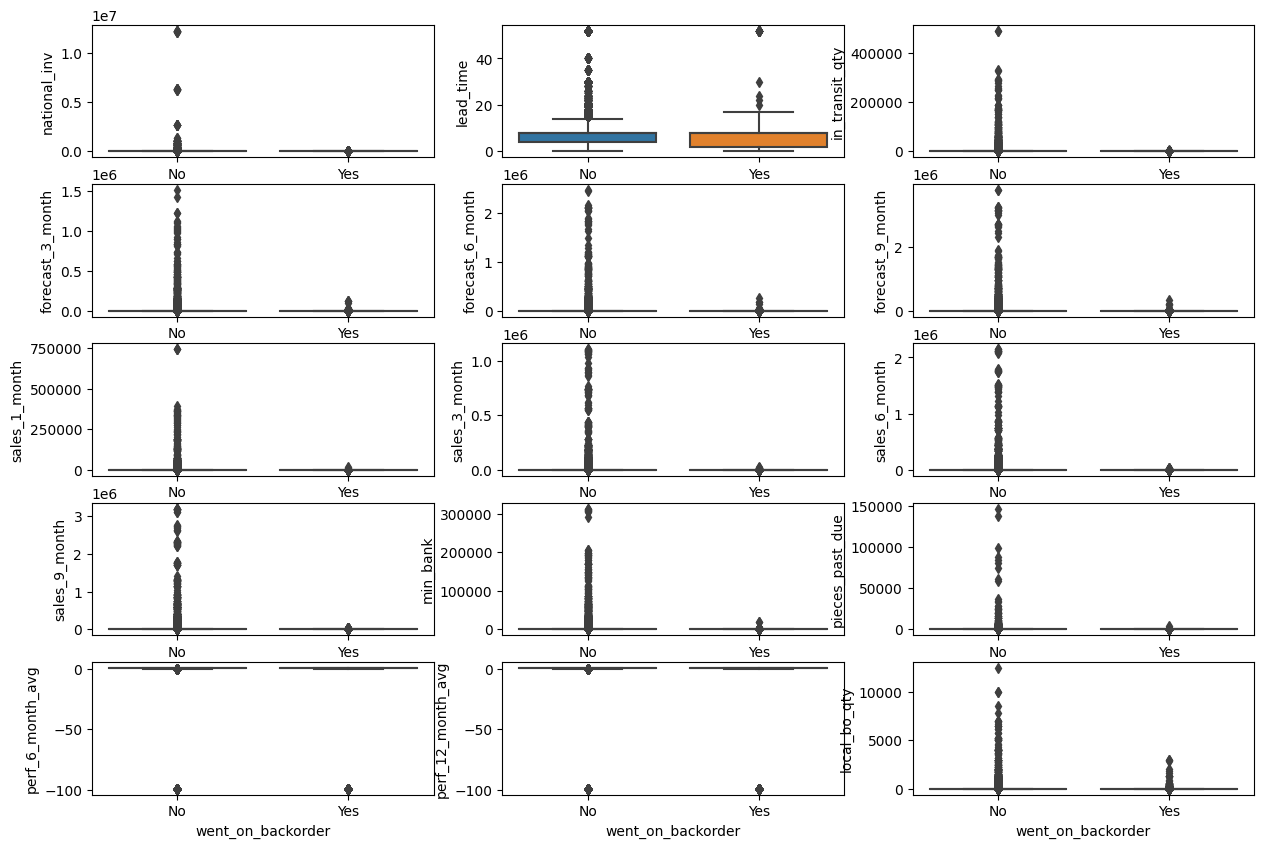

In [26]:
num_cols = [col for col in df.columns if df[col].dtype!="O"]
fig, ax = plt.subplots(5,3)
fig.set_size_inches(15,10)
ax = ax.flatten()

for ax, col in zip(ax,num_cols):
    sns.boxplot(x = df["went_on_backorder"],y= df[col], ax= ax)

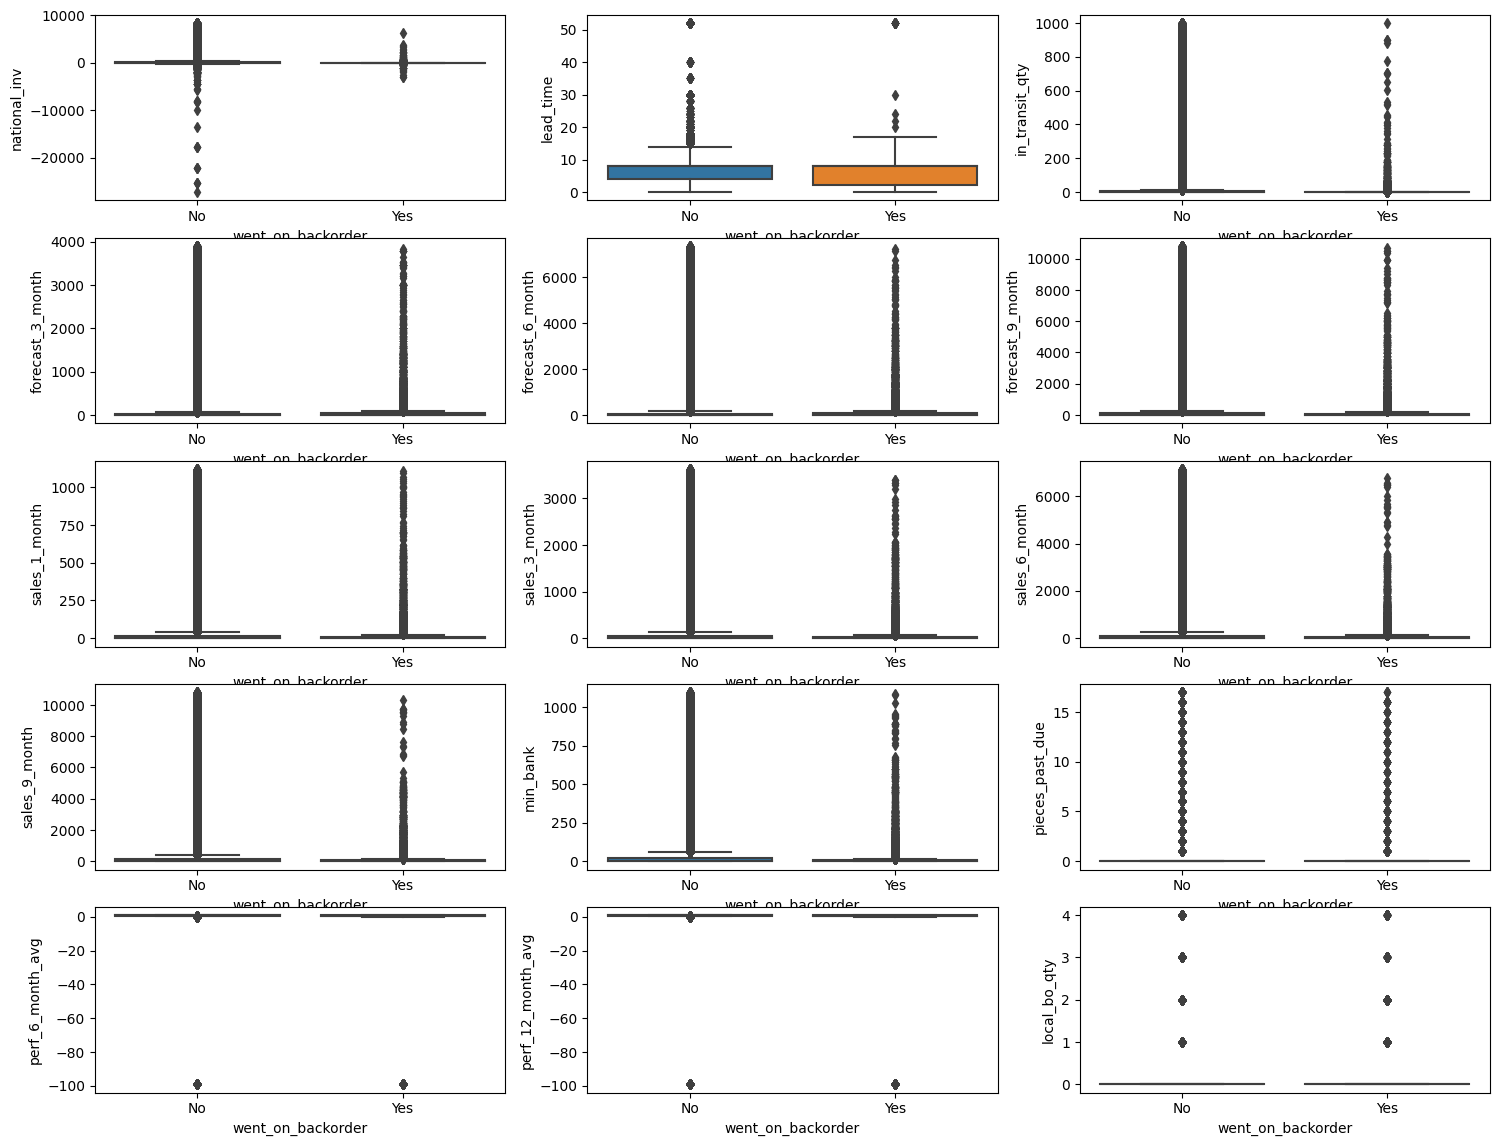

In [27]:
num_cols = [col for col in df.columns if df[col].dtype!="O"]
fig, ax = plt.subplots(5,3)
fig.set_size_inches(18,14)
ax = ax.flatten()

for ax, col in zip(ax,num_cols):
    df1 = df[[col, "went_on_backorder"]]
    df1 = df1[df1[col] <= df1[col].quantile(0.99)]
    sns.boxplot(x= df1["went_on_backorder"], y = df1[col], ax= ax)

/tmp/ipykernel_307/3648873261.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<AxesSubplot: >

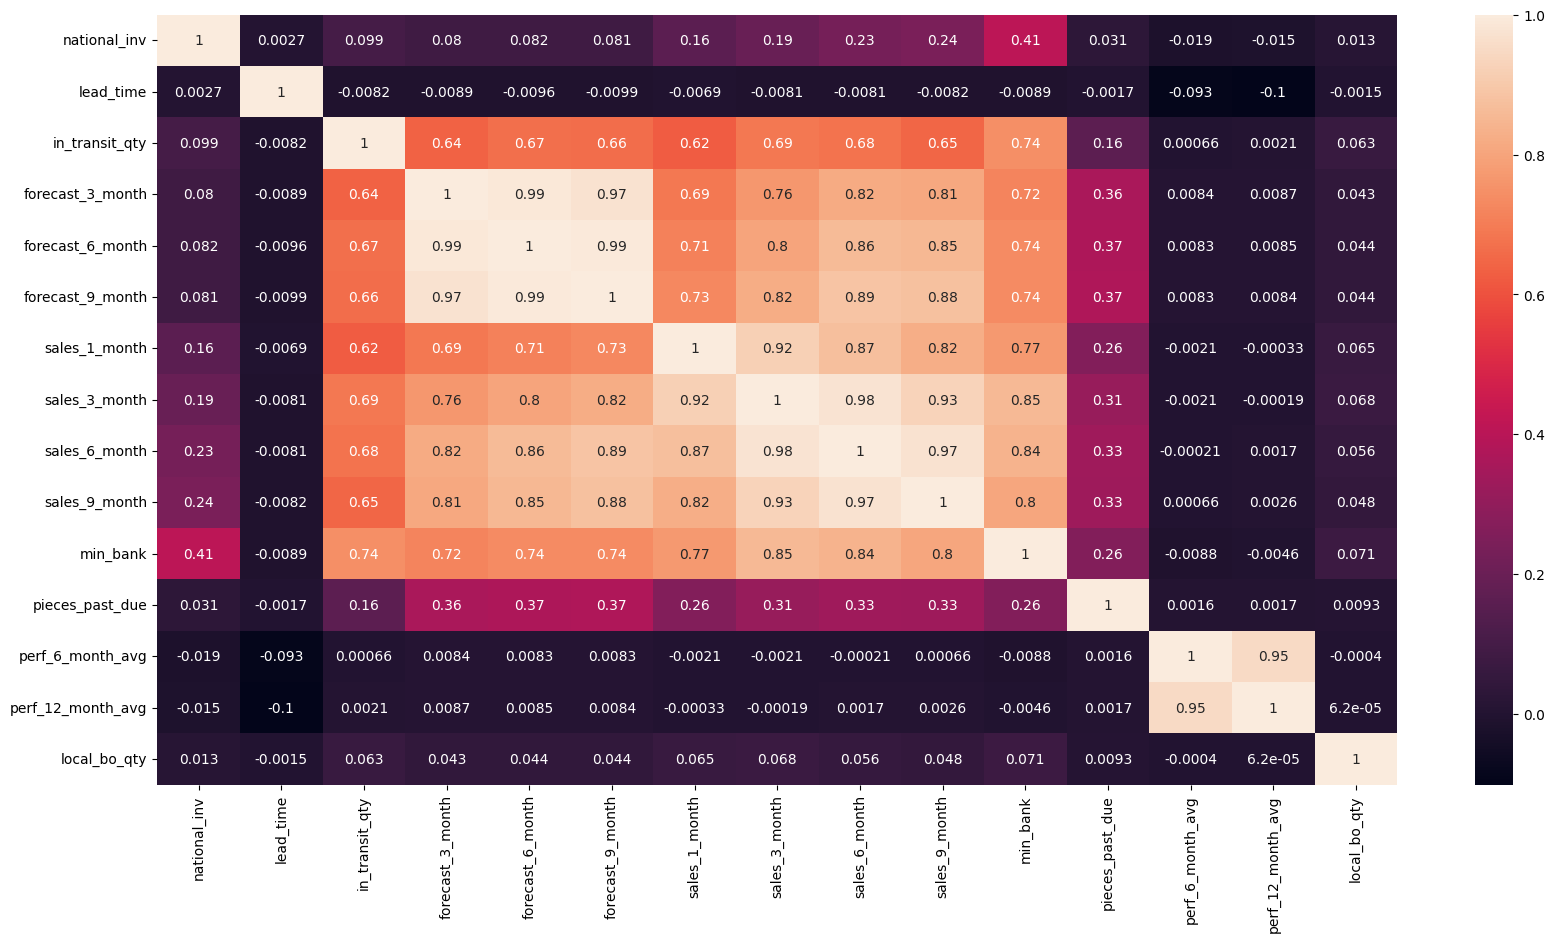

In [28]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)


Comment

From the correlation matrix , we can easily interpret that features from in_transit_qty to min_bank are more correlated with each other. Also the perf_6_months_avg and perf_12_months_avg is highly correlated with each other.

Apart from the above mentioned features, other features are very weakly correlated.

As many features are correlated the linear models like logistic regression, Linear SVM and other linear models may not perform well as
the coeffiecients of separating plane change.

the sales features are highly correlated with each other by  ~1. so we can consider only one of them as sales feature and remove the remaining.

Similarly, the forecast features also correlated with each other by ~1. so we can use one of them as forecast feature and remove the remaining


## "national_inv" feature analysis

Q: is 'Inventory' feature is important for predicting Backorders?

- Generally we get backorders on a product when there is no stock available but an order gets placed, this means that when we have 0 inventory and still take orders. When an order gets placed even though there is no stock, inventory value becomes negative. So the chances of backorders is high when inventory is 0 or a -ve value.

- Another case where a business could have backorders is when the business takes orders that require more quantity than the stock available in the inventory. It means that even there are items available in the inventory but they are not sufficient for the order placed and requires more items. This could possibly happen when the inventory available is less than minimum recommended stock.

 *The national_inv has outlier values after the 99th percentile, lets analyse this feature by removing it*

In [29]:
df1 = df[df["national_inv"]< df["national_inv"].quantile(0.99)]

In [30]:
print(df1.shape)
np.round(df1["national_inv"].describe(),2)

(1124804, 22)


count    1124804.00
mean         256.95
std          761.92
min       -27256.00
25%            9.00
50%           37.00
75%          151.00
max         8382.00
Name: national_inv, dtype: float64

In [32]:
get_percentile_values(df1)

,col_name,0_th,10_th,20_th,30_th,40_th,50_th,60_th,70_th,80_th,90_th,100_th,91_th,92_th,93_th,94_th,95_th,96_th,97_th,98_th,99_th,99.0_th,99.1_th,99.2_th,99.3_th,99.4_th,99.5_th,99.6_th,99.7_th,99.8_th,99.9_th,100.0_th
0,national_inv,-27256.0,3.00,6.00,11.00,20.00,37.00,64.00,110.00,214.00,537.00,8382.0,612.00,711.00,832.00,985.00,1194.00,1519.00,2020.00,2863.00,4499.00,4499.00,4680.773,4845.000,4970.000,5160.0,5514.000,5914.000,6354.591,6942.000,7624.197,8382.0
1,lead_time,0.0,2.00,2.00,4.00,8.00,8.00,8.00,8.00,8.00,12.00,52.0,12.00,12.00,12.00,12.00,12.00,13.00,15.00,26.00,52.00,52.00,52.000,52.000,52.000,52.0,52.000,52.000,52.000,52.000,52.000,52.0
2,in_transit_qty,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,9.00,47.00,186624.0,56.00,68.00,84.00,105.00,136.00,184.00,257.00,401.00,774.00,774.00,847.000,947.000,1050.000,1193.0,1390.000,1634.000,2015.000,2590.788,3800.000,186624.0
3,forecast_3_month,0.0,0.00,0.00,0.00,0.00,0.00,4.00,16.00,52.00,216.00,739584.0,252.00,303.00,379.00,473.00,600.00,787.00,1063.00,1617.00,2975.97,2975.97,3185.773,3510.000,3871.000,4250.0,4914.000,5665.576,6825.773,8800.000,12580.394,739584.0
4,forecast_6_month,0.0,0.00,0.00,0.00,0.00,3.00,13.00,40.00,115.00,433.00,1202688.0,504.00,600.00,742.00,920.00,1150.00,1500.00,2013.00,3036.00,5460.00,5460.00,5940.000,6377.728,7035.895,7840.0,8928.000,10280.000,12551.182,16358.304,22979.122,1202688.0
5,forecast_9_month,0.0,0.00,0.00,0.00,0.00,6.00,23.00,65.00,180.00,645.00,1513728.0,767.00,909.00,1084.00,1350.00,1699.00,2176.00,3000.00,4500.00,8000.00,8000.00,8623.319,9432.000,10350.000,11424.0,12879.850,15120.000,18408.274,23786.970,33298.244,1513728.0
6,sales_1_month,0.0,0.00,0.00,0.00,1.00,2.00,5.00,10.00,24.00,77.00,741774.0,91.00,107.00,129.00,158.00,196.00,251.88,338.00,499.00,869.00,869.00,937.000,1016.000,1107.000,1223.0,1376.000,1604.000,1952.000,2498.000,3499.000,741774.0
7,sales_3_month,0.0,0.00,1.00,2.00,5.00,9.00,17.00,34.00,79.00,256.00,742121.0,297.00,351.00,423.00,515.00,637.00,812.00,1086.91,1593.00,2765.00,2765.00,2971.000,3226.000,3521.379,3932.0,4438.985,5111.788,6141.000,7778.000,10966.182,742121.0
8,sales_6_month,0.0,0.00,2.00,5.00,10.00,18.00,35.00,71.00,163.00,514.00,742763.0,595.00,700.00,844.00,1020.00,1255.00,1589.00,2146.00,3130.00,5403.00,5403.00,5793.546,6301.576,6915.379,7704.0,8584.000,10084.788,11921.591,14892.000,20749.576,742763.0
9,sales_9_month,0.0,0.00,3.00,7.00,15.00,27.00,53.00,108.00,248.00,780.00,1703428.0,904.00,1064.00,1276.00,1546.00,1898.00,2412.00,3260.00,4739.94,8200.00,8200.00,8796.000,9514.000,10466.000,11552.0,12903.985,15061.576,17915.364,22572.000,31488.379,1703428.0


In [67]:
df1.went_on_backorder.value_counts()

No     1111888
Yes      12916
Name: went_on_backorder, dtype: int64

In [68]:
print(df1[df1["national_inv"]<= 0].went_on_backorder.value_counts())
print(df1[df1["national_inv"]<= 2].went_on_backorder.value_counts()["Yes"]/(df1.went_on_backorder.value_counts()["Yes"]))
print(df1[df1["national_inv"]<= 2].went_on_backorder.value_counts()["No"]/(df1.went_on_backorder.value_counts()["No"]))



No     44423
Yes     5066
Name: went_on_backorder, dtype: int64
0.5824558686899969
0.0913122544716734


 *here, it is showing that if the national_inv values is <= 2, it is abe to classify as item backordered 58% out of all the backordered items. so, this feature will be very useful during training of the model*

*also, if we consider inventory<= 2  as backordered items then it is misclassifying the 9% of the non-backordered items as backordered. even this percentage is smaller,since there is huge imbalance in the target column categories, it will be 44423 items misclassified.*

*from the correlation matrix, we can observe that national_inv is more correlated to min_bank which is true in many cases, because when the inventory stock is less than recommended stock, there will be chance of backorder*

## lead_time

<AxesSubplot: ylabel='Frequency'>

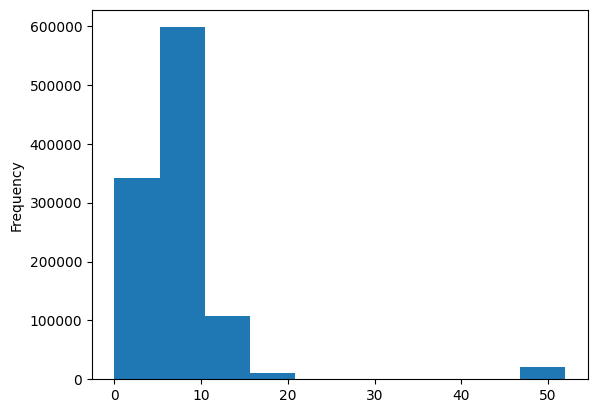

In [136]:
df1.lead_time.plot.hist()

*from the plot, it is showing the most of the values of lead_time are b/w 0 and 25*

In [151]:
df1[df1.lead_time >  16].went_on_backorder.value_counts()


No     25650
Yes       41
Name: went_on_backorder, dtype: int64

In the real world if a product has longer lead time retailer will try to keep more units in stock to avoid Backorders. That is the reason we didn't observe many Backorders when lead time is greater than 17, a Business will take Backorders mostly if they knew the lead time is short.

So for a Business to accept Backorders, products should have shorter lead time. But this doesn't mean only products that run into backorders have shorter lead time Non-Backorders can also have shroter lead time and that is the reason there is no difference between lead time of Backorders and Non-Backorders. So we can't really make a decision just based on lead time.

## in_transit_qty

<AxesSubplot: xlabel='went_on_backorder', ylabel='perf_6_month_avg'>

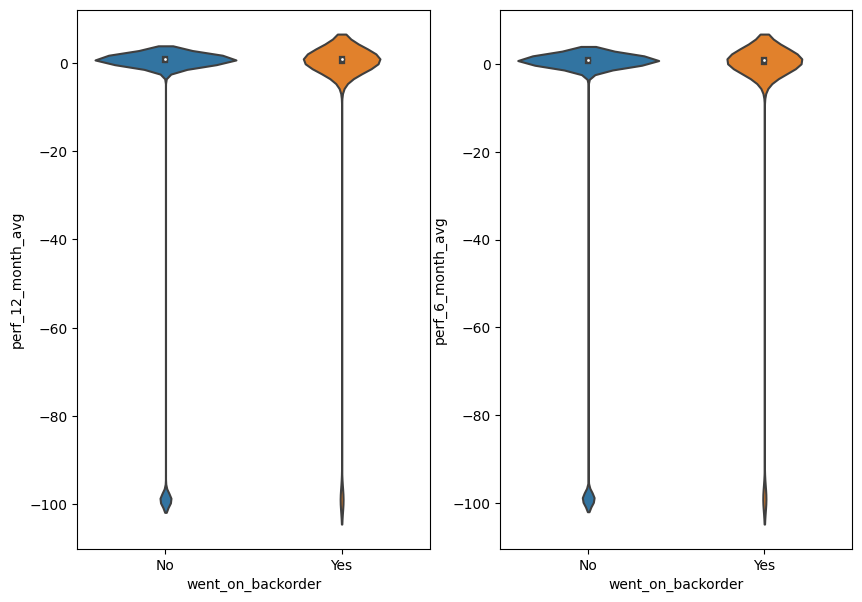

In [ ]:
fig, axes = plt.subplots(1,2)
ax = axes.flatten()
fig.set_size_inches(10,7)
sns.violinplot(x=df["went_on_backorder"] ,y =df["perf_12_month_avg"], ax= ax[0] )
sns.violinplot(x=df["went_on_backorder"] ,y =df["perf_6_month_avg"], ax= ax[1] )

## Categorical features

In [ ]:
cat_cols = [col for col in df.columns if df[col].dtype=="O"]
fig, ax = plt.subplots(5,3)
fig.set_size_inches(18,14)
ax = ax.flatten()

for ax, col in zip(ax,cat_cols):
    df1 = df[[col, "went_on_backorder"]]
    df1 = df1[df1[col] <= df1[col].quantile(0.8)]
    sns.barplot(x= df1["went_on_backorder"], y = df1[col], ax= ax)

In [ ]:
def uniVariate_categorical(cat_column):
    
    count_values = df.groupby([cat_column,'went_on_backorder']).size().unstack()

    print(count_values)
    percentage_of_values = count_values.T.div(count_values.T.sum()).T

    print(percentage_of_values)

    fig,ax = plt.subplots()
    percentage_of_values.plot(kind='bar',ax=ax)

    ax.set_xlabel(cat_column)
    ax.set_xticklabels(['No','Yes'],rotation=0)
    ax.set_ylabel("percentage_of_values")
    ax.set_title(f"bar plots of {cat_column}")

went_on_backorder       No    Yes
rev_stop                         
No                 1915119  13977
Yes                    835      4
went_on_backorder        No       Yes
rev_stop                             
No                 0.992755  0.007245
Yes                0.995232  0.004768


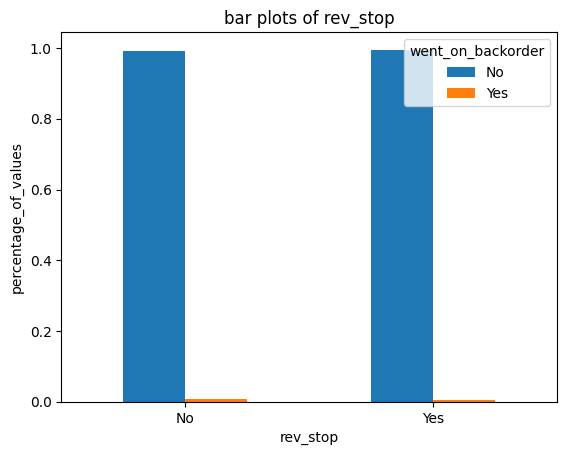

In [ ]:
uniVariate_categorical("rev_stop")

Comment

    When rev_stop is NO ,product did not go to backorder 1,915119 times ie 99.27%.
    When rev_stop is NO, product did go to backorder 13,977 times ie 0.7245%.
    When rev_stop is YES,product did not go to backorder 835 times ie 99.52%.
    When rev_stop is YES,product did go to backorder 4 times ie 0.4768%.
    When rev_stop is NO ,The Ratio of products that went to backorder is very close to the Class Ratio.

The value of rev_stop being 0 or 1 , the chances of product going to backorder is extremely low.

went_on_backorder       No    Yes
potential_issue                  
No                 1915019  13927
Yes                    935     54
went_on_backorder        No       Yes
potential_issue                      
No                 0.992780  0.007220
Yes                0.945399  0.054601


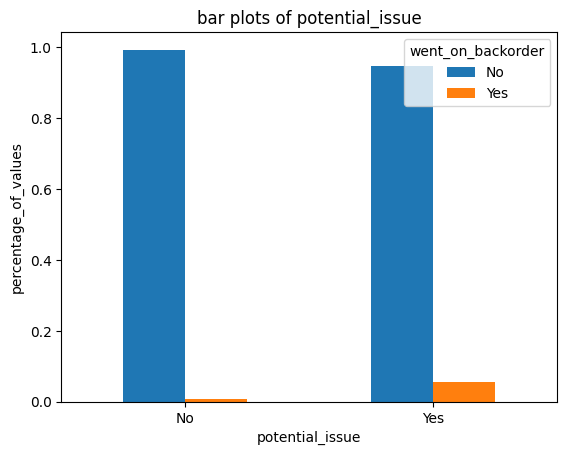

In [ ]:
uniVariate_categorical("potential_issue")


Comment

    When potential_issue is NO ,product did not go to backorder 1,915019 times ie 99.2780%.
    When potential_issue is NO, product did go to backorder 13927 times ie 0.7241%.
    When potential_issue is YES,product did not go to backorder 935 times ie 94.5399%.
    When potential_issue is YES,product did go to backorder 54 times ie 05.4601%



went_on_backorder       No    Yes
oe_constraint                    
No                 1915671  13972
Yes                    283      9
went_on_backorder        No       Yes
oe_constraint                        
No                 0.992759  0.007241
Yes                0.969178  0.030822


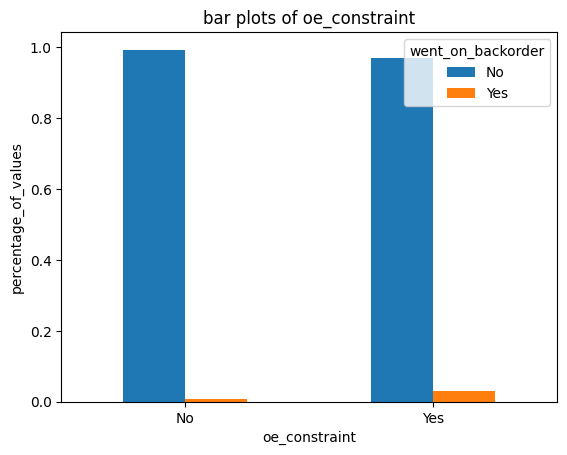

In [ ]:
uniVariate_categorical("oe_constraint")

Comment

    When oe_constraint is NO ,product did not go to backorder 1,915671 times ie 99.2759%.
    When oe_constraint is NO, product did go to backorder 13972 times ie 0.7241%.
    When oe_constraint is YES,product did not go to backorder 283 times ie 96.9178%.
    When oe_constraint is YES,product did go to backorder 9 times ie 0.030822%


went_on_backorder       No    Yes
ppap_risk                        
No                 1685533  11850
Yes                 230421   2131
went_on_backorder        No       Yes
ppap_risk                            
No                 0.993019  0.006981
Yes                0.990836  0.009164


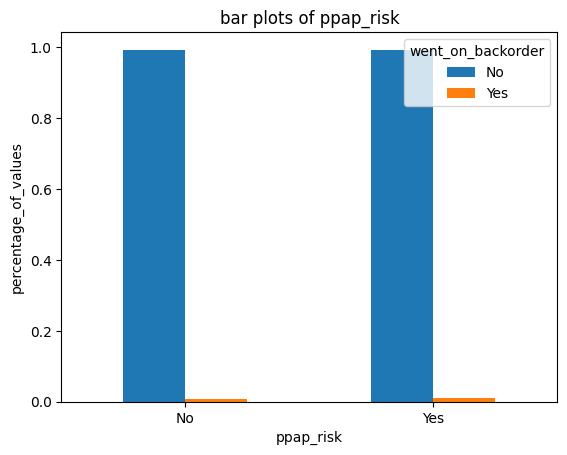

In [ ]:
uniVariate_categorical("ppap_risk")


Comment

    When ppap_risk is NO ,product did not go to backorder 1,685533 times ie 99.3019%.
    When ppap_risk is NO, product did go to backorder 11850 times ie 0.6981%.
    When ppap_risk is YES,product did not go to backorder 230421 times ie 99.0836%.
    When ppap_risk is YES,product did go to backorder 2131 times ie 0.9164%


went_on_backorder       No    Yes
deck_risk                        
No                 1482778  11704
Yes                 433176   2277
went_on_backorder        No       Yes
deck_risk                            
No                 0.992169  0.007831
Yes                0.994771  0.005229


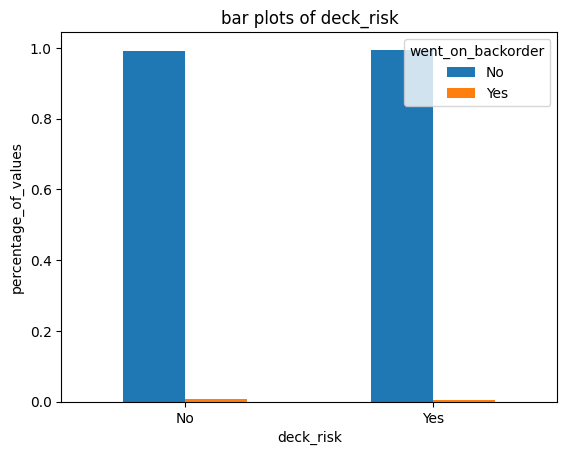

In [ ]:
uniVariate_categorical("deck_risk")

went_on_backorder       No    Yes
stop_auto_buy                    
No                   69966    578
Yes                1845988  13403
went_on_backorder        No       Yes
stop_auto_buy                        
No                 0.991807  0.008193
Yes                0.992792  0.007208


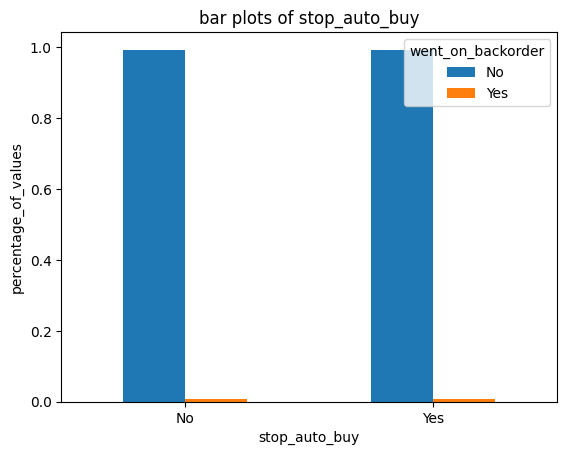

In [ ]:
uniVariate_categorical("stop_auto_buy")


Comment

    When rev_stop is NO ,product did not go to backorder 69966 times ie 99.1807%.
    When rev_stop is NO, product did go to backorder 578 times ie 0.8193%.
    When rev_stop is YES,product did not go to backorder 1,845988 times ie 99.2792%.
    When rev_stop is YES,product did go to backorder 13403 times ie 0.7208%.
    When stop_auto_buy is YES ,The Ratio of products that went to backorder is very close to the Class Ratio.

With Feature stop_auto_buy being 0 or 1, the chance of product going to backorder is extremely low.


## creating the train and test dataset for the experiments

In [31]:
df1.drop(columns=["forecast_3_month","forecast_9_month","sales_9_month","sales_3_month","sales_1_month","perf_6_month_avg"],inplace=True)

/tmp/ipykernel_307/3074364389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns=["forecast_3_month","forecast_9_month","sales_9_month","sales_3_month","sales_1_month","perf_6_month_avg"],inplace=True)


In [32]:
df = df1.copy()

In [4]:
df= pd.read_csv("selected_features_dataset.csv")

In [5]:
df

,national_inv,lead_time,in_transit_qty,forecast_6_month,sales_6_month,min_bank,potential_issue,pieces_past_due,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,0.0,NaN,0.0,0.0,0.0,0.0,No,0.0,-99.00,0.0,No,No,No,Yes,No,No
1,2.0,9.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.0,No,No,No,Yes,No,No
2,2.0,NaN,0.0,0.0,0.0,0.0,No,0.0,-99.00,0.0,Yes,No,No,Yes,No,No
3,7.0,8.0,0.0,0.0,0.0,1.0,No,0.0,0.13,0.0,No,No,No,Yes,No,No
4,8.0,NaN,0.0,0.0,0.0,2.0,No,0.0,-99.00,0.0,Yes,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124799,16.0,2.0,0.0,16.0,16.0,0.0,No,0.0,0.17,0.0,No,No,No,Yes,No,No
1124800,61.0,4.0,0.0,0.0,21.0,3.0,No,0.0,0.78,0.0,No,No,No,Yes,No,No
1124801,5.0,4.0,6.0,2.0,27.0,2.0,No,0.0,0.78,0.0,No,No,No,Yes,No,No
1124802,165.0,NaN,0.0,180.0,215.0,40.0,No,0.0,-99.00,0.0,No,No,No,Yes,No,No


## Seperating dependent and independent features
## encoding target feature values manually  

In [6]:
x = df.drop(columns=["went_on_backorder"])
y = df["went_on_backorder"]
y = y.replace({"No":0, "Yes":1})

## replacing the -99 values in the performance_x_month_avg features with Nan

In [7]:
x[["perf_12_month_avg"]] = x[["perf_12_month_avg"]].replace(-99.0,np.NaN)
x.isna().sum()

national_inv             0
lead_time            45061
in_transit_qty           0
forecast_6_month         0
sales_6_month            0
min_bank                 0
potential_issue          0
pieces_past_due          0
perf_12_month_avg    55678
local_bo_qty             0
deck_risk                0
oe_constraint            0
ppap_risk                0
stop_auto_buy            0
rev_stop                 0
dtype: int64

In [8]:

x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y, random_state= 42)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size= 0.2, stratify = y_train, random_state= 42)

In [9]:
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,719874.0,257.378150,762.479439,-27256.0,9.00,36.00,151.00,8382.0
lead_time,691142.0,7.686393,7.116313,0.0,4.00,8.00,8.00,52.0
in_transit_qty,719874.0,41.032082,534.510174,0.0,0.00,0.00,4.00,186624.0
forecast_6_month,719874.0,308.573092,3778.759633,0.0,0.00,3.00,67.00,1202688.0
sales_6_month,719874.0,311.618926,2192.489904,0.0,3.00,18.00,104.00,742763.0
min_bank,719874.0,51.549502,337.158493,0.0,0.00,2.00,23.00,81757.0
pieces_past_due,719874.0,1.965284,172.625638,0.0,0.00,0.00,0.00,137625.0
perf_12_month_avg,684270.0,0.794498,0.227064,0.0,0.72,0.87,0.96,1.0
local_bo_qty,719874.0,0.835366,30.620206,0.0,0.00,0.00,0.00,6965.0


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,1124804.0,256.951184,761.924327,-27256.0,9.00,37.00,151.00,8382.0
lead_time,1079743.0,7.688336,7.118687,0.0,4.00,8.00,8.00,52.0
in_transit_qty,1124804.0,40.695864,473.361986,0.0,0.00,0.00,4.00,186624.0
forecast_6_month,1124804.0,306.916900,3577.267067,0.0,0.00,3.00,67.00,1202688.0
sales_6_month,1124804.0,310.714293,2329.217109,0.0,3.00,18.00,104.00,742763.0
min_bank,1124804.0,51.168215,331.525291,0.0,0.00,2.00,23.00,81757.0
pieces_past_due,1124804.0,1.882551,141.882640,0.0,0.00,0.00,0.00,137625.0
perf_12_month_avg,1124804.0,-4.145247,21.647579,-99.0,0.69,0.85,0.96,1.0
local_bo_qty,1124804.0,0.873638,32.668945,0.0,0.00,0.00,0.00,6965.0


In [11]:
y_train.value_counts()

0    711608
1      8266
Name: went_on_backorder, dtype: int64

In [12]:
y_test.value_counts()

0    222378
1      2583
Name: went_on_backorder, dtype: int64

## function to get the metrics and train the models

In [22]:
from prettytable import PrettyTable

def evaluate_clf(classifier_name,train_true, train_predicted, test_true, test_predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''

    fig, axes = plt.subplots(1,3, figsize=(17,4))
    ax = axes.flatten()
    plt.suptitle(t=classifier_name+" classifier", size=16)
    test_confusion_matrix = confusion_matrix(y_true= test_true, y_pred=test_predicted)
    train_confusion_matrix = confusion_matrix(y_true=train_true, y_pred=train_predicted)
    sns.heatmap(train_confusion_matrix, annot=True,ax= ax[0],fmt='d')
    ax[0].set_title("validation confusion matrix")
    sns.heatmap(test_confusion_matrix, annot=True,ax= ax[1],fmt='d')
    ax[1].set_title("test confusion matrix")
    
    # for training
    train_acc = accuracy_score(train_true, train_predicted) # Calculate Accuracy
    train_f2 = round(fbeta_score(train_true,train_predicted, pos_label = 1,average='weighted', beta=2),4) # Calculate F2-score
    train_precision = precision_score(train_true, train_predicted) # Calculate Precision
    train_recall = recall_score(train_true, train_predicted)  # Calculate Recall
    train_roc_auc = roc_auc_score(train_true, train_predicted) #Calculate Roc_auc score

    #for testing
    test_acc = accuracy_score(test_true, test_predicted) # Calculate Accuracy
    test_f2 = round(fbeta_score(test_true,test_predicted, pos_label = 1,average='weighted', beta=2),4) # Calculate F2-score
    test_precision = precision_score(test_true, test_predicted) # Calculate Precision
    test_recall = recall_score(test_true, test_predicted)  # Calculate Recall
    test_roc_auc = roc_auc_score(test_true, test_predicted) #Calculate Roc_auc score

    train_fpr,train_tpr,train_threshold=roc_curve(train_true,train_predicted)
    test_fpr,test_tpr,test_threshold=roc_curve(test_true,test_predicted)

    plt.plot(train_fpr,train_tpr,label=f'Train auc  = {train_roc_auc}')
    plt.plot(test_fpr,test_tpr,label=f'Test auc   ={test_roc_auc}')    
    plt.legend()
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('TPR vs FPR graph')
    plt.grid()
    plt.show()

    table = PrettyTable(["set","`accuracy_score","F2_score","precision_score","recall_score","roc_auc_score"])

    table.add_row(["train",train_acc, train_f2,train_precision,train_recall,train_roc_auc])
    table.add_row(["test",test_acc,test_f2,train_precision,test_recall,test_roc_auc])
    evaluation_metrics = pd.DataFrame({"model_name":[classifier_name],
                                        "train_acc":[train_acc],
                                        "test_acc":[test_acc], 
                                        "train_f2":[train_f2],
                                        "test_f2":[test_f2],
                                        "train_precision":[train_precision],
                                        "test_precision":[test_precision],
                                        "train_recall":[train_recall],
                                        "test_recall":[test_recall],
                                        "train_roc_auc":[train_roc_auc],
                                        "test_roc_auc":[test_roc_auc]})                        
    print(table)
    return evaluation_metrics


In [33]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

grid_search_params = {
    "Random Forest": {'n_estimators':[10,50,100,200],
                        'max_depth':[1, 5, 10,15],
                        'class_weight':[{0:0.1,1:0.9},{0:0.3,1:0.7},{0:0.2,1:0.8}]
                },
    "Decision Tree": {'max_depth':[1, 5, 10, 50],
                        'min_samples_split':[5, 10, 100, 500,1000],
                        'class_weight':[{0:0.1,1:0.9},{0:0.2,1:0.8},'balanced']},
    "Logistic Regression":  {'C':[10 ** x for x in range(-5, 4)],
                                    'penalty':['l1','l2'],
                                    'class_weight':[{0:0.1,1:0.9},{0:0.2,1:0.8},'balanced']},
    "XGBClassifier": {
                        'max_depth':[5,10,15,20],
                        'min_child_weight':[10,20,30,50]
                     }
                    }

In [34]:
def get_models_report(x_train,y_train,x_test, y_test,preprocessor_pipeline,models:dict):
    
    ### splitting the dataset into train, test sets
    # x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.95, stratify=y, random_state= 40)

    evaluation_df = pd.DataFrame()
    model_items = list(models.items())
    for i in tqdm(range(len(models.values()))):
        model_name ,model_obj = model_items[i][0], model_items[i][1]
        if model_name in list(grid_search_params.keys()):
            grid_params = grid_search_params[model_name]
        
        classifier_step = (model_name+"grid_searched",
                           GridSearchCV(cv=5, estimator=model_obj,
                                        param_grid=grid_params,return_train_score=True,scoring='roc_auc',n_jobs=-1 ))
        preprocessor_pipeline.steps.append(classifier_step)
        print(f"{'*-'*10} started Training {model_name}{'*-'*10}")
        preprocessor_pipeline.fit(x_train,y_train)
        print(f"best_params: {preprocessor_pipeline.best_params_}")
        
        ## make predictions
        y_train_pred = preprocessor_pipeline.predict(x_train)
        y_test_pred = preprocessor_pipeline.predict(x_test)

        preprocessor_pipeline.steps.remove(classifier_step)
        ## get the evaluation metrics for train and test 
        evaluation_metrics_df = evaluate_clf(model_name,y_train, y_train_pred,y_test, y_test_pred)
        evaluation_df = pd.concat([evaluation_df, evaluation_metrics_df])
    return evaluation_df

       

    # return df1

## Experiment 1
### knn imputer , Robust scaler, SmoteTomek


## Baseline model

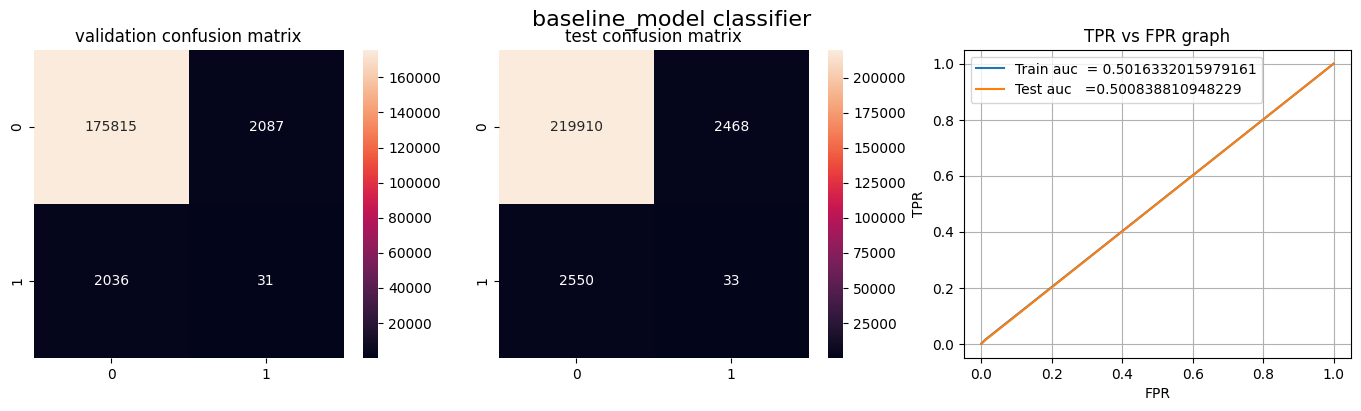

+-------+--------------------+----------+----------------------+----------------------+--------------------+
|  set  |  `accuracy_score   | F2_score |   precision_score    |     recall_score     |   roc_auc_score    |
+-------+--------------------+----------+----------------------+----------------------+--------------------+
| train | 0.9770904989192584 |  0.9771  | 0.014636449480642116 | 0.014997581035316884 | 0.5016332015979161 |
|  test | 0.9776939113890852 |  0.9776  | 0.014636449480642116 | 0.012775842044134728 | 0.500838810948229  |
+-------+--------------------+----------+----------------------+----------------------+--------------------+


In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
import tqdm as tq

dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(x_train,y_train)
y_valid_pred = dummy_clf.predict(x_valid)
y_test_pred = dummy_clf.predict(x_test)
evaluation_metrics_df = evaluate_clf("baseline_model",y_valid, y_valid_pred,y_test, y_test_pred)


## Experiment 2

In [35]:
cat_columns = [col for col in x_train.columns if df[col].dtype=="O"]
num_columns = [col for col in x_train.columns if df[col].dtype!="O"]

numeric_transformer = Pipeline(steps = [
    ("missing_value_imputer", SimpleImputer(strategy="median")),
    ("feature_scaling", RobustScaler())
    ])

categorical_transformer = Pipeline(steps= [
    ("categorical_encoding",OneHotEncoder(handle_unknown="ignore", drop="first"))
])


# smote_transformer = Pipeline(steps= [
#     ("smoteTomeklinks",SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1))
# ])

In [36]:
data_preprocessing = ColumnTransformer(transformers= [
                      
                      ("cat_transformer", categorical_transformer, cat_columns),
                    #   ("smote_transformer",smote_transformer,list(x.columns)),
                      ("num_transformer", numeric_transformer,num_columns),
])

In [37]:
preprocessor_pipeline = Pipeline(steps = [
    ("data_preprocessing",data_preprocessing)
])

In [38]:
exp1_evalution_df = get_models_report(x_train,y_train,x_test, y_test,preprocessor_pipeline,models)

  0%|          | 0/8 [00:00<?, ?it/s]

*-*-*-*-*-*-*-*-*-*- started Training Random Forest*-*-*-*-*-*-*-*-*-*-


  0%|          | 0/8 [2:21:22<?, ?it/s]


AttributeError: 'Pipeline' object has no attribute 'best_params_'

In [54]:
### logistic regression

log_reg = LogisticRegression(penalty='l2',class_weight="balanced",C=100)

pipeline = Pipeline(steps = [
    ("data_preprocessing",data_preprocessing),
    ("classifier",log_reg)
])
pipeline.fit(x_train, y_train)

y_test_pred = pipeline.predict(x_test)
acc, f1 , precision, recall, roc_auc = evaluate_clf(y_test, y_test_pred)

print(f"""
        ***model_performance for test set***
        test_acc ={acc}, 
        test_f1={f1}, 
        test_precision={precision}, 
        test_recall={recall}, 
        test_roc_auc={roc_auc}
        """)

/config/workspace/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



        ***model_performance for test set***
        test_acc =0.5998927223048701, 
        test_f1=0.05177511676089476, 
        test_precision=0.02661179698216735, 
        test_recall=0.9512258064516129, 
        test_roc_auc=0.7735185713524497
        


In [ ]:
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, stratify=y, random_state= 40)




grid_param_RF ={"classifier": [RandomForestClassifier(class_weight = "balanced_subsample")],
                 "classifier__n_estimators":[50,100,200,400], 
                 "classifier__max_depth":[2,4,5,7,9],
                 "classifier__random_state":[13]}

grid_search_RF = GridSearchCV(pipeline,param_grid=grid_param_RF,cv=5, verbose = 0, n_jobs = -1)
grid_search_RF.fit(X_resample,y_resample)



ValueError: ignored

In [ ]:
y_test_pred = grid_search_RF.predict(x_test)
acc, f1 , precision, recall, roc_auc = evaluate_clf(y_test, y_test_pred)

print(f"""
        ***model_performance for test set***
        test_acc ={acc}, 
        test_f1={f1}, 
        test_precision={precision}, 
        test_recall={recall}, 
        test_roc_auc={roc_auc}
        """)

In [ ]:
y_test_pred = pipeline.predict(x_test)

In [ ]:
acc, f1 , precision, recall, roc_auc = evaluate_clf(y_test, y_test_pred)

print(f"""
        ***model_performance for test set***
        test_acc ={acc}, 
        test_f1={f1}, 
        test_precision={precision}, 
        test_recall={recall}, 
        test_roc_auc={roc_auc}
        """)


        ***model_performance for test set***
        test_acc =0.9939459132323559, 
        test_f1=0.350744609913314, 
        test_precision=0.7858565737051793, 
        test_recall=0.2257510729613734, 
        test_roc_auc=0.6126511054394728
        


In [ ]:
cat_columns = [col for col in x.columns if df[col].dtype=="O"]
print(cat_columns)

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']


## experiment 3

In [40]:
cat_columns = [col for col in x.columns if df[col].dtype=="O"]
num_columns = [col for col in x.columns if df[col].dtype!="O"]

numeric_transformer = Pipeline(steps = [
    ("missing_value_imputer", SimpleImputer(strategy="median")),
    ])

categorical_transformer = Pipeline(steps= [
    ("categorical_encoding",OneHotEncoder(handle_unknown="ignore", drop="first"))
])


In [41]:
cat_columns = [col for col in x.columns if df[col].dtype=="O"]
num_columns = [col for col in x.columns if df[col].dtype!="O"]

data_preprocessing = ColumnTransformer(transformers= [
                      
                      ("cat_transformer", categorical_transformer, cat_columns),
                      ("num_transformer", numeric_transformer,num_columns),
])

In [42]:
pipeline_transformer = Pipeline(steps = [
    ("data_preprocessing",data_preprocessing),
])

In [83]:
tran_arr =pipeline_transformer.fit_transform(x_train)

In [84]:
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)

In [85]:
x_res, y_res  = smt.fit_resample(tran_arr,y_train)

In [86]:
num_columns = [col for col in x.columns if df[col].dtype!="O"]

pipeline_trainer = Pipeline(steps = [
    ("feature_scaling", RobustScaler())
    ])

In [87]:
x_test_trans = pipeline_transformer.transform(x_test)

In [88]:
pd.DataFrame(x_test_trans)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.97,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,240.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.99,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,36.0,8.0,11.0,8.0,29.0,58.0,8.0,29.0,62.0,91.0,14.0,0.0,0.90,0.90,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,128.0,2.0,3.0,0.0,99.0,198.0,22.0,71.0,134.0,213.0,37.0,0.0,0.99,0.98,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,13.0,12.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.48,0.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964963,0.0,0.0,0.0,0.0,1.0,0.0,26.0,8.0,23.0,20.0,40.0,60.0,5.0,20.0,41.0,62.0,14.0,0.0,1.00,0.99,0.0
964964,0.0,1.0,0.0,0.0,1.0,0.0,61.0,2.0,0.0,24.0,78.0,138.0,12.0,52.0,68.0,69.0,7.0,0.0,0.98,0.92,0.0
964965,0.0,0.0,0.0,0.0,1.0,0.0,18.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.94,0.83,0.0
964966,0.0,0.0,0.0,0.0,1.0,0.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98,0.98,0.0


In [89]:
df2 = get_models_report(x_res,y_res,x_test_trans, y_test,pipeline_trainer,models)

: 

: 

In [ ]:
df2

,model_name,test_acc,test_f1,test_precision,test_recall,test_roc_auc
0,Random Forest,0.989940,0.220456,0.251301,0.196356,0.596044
0,Decision Tree,0.981740,0.159389,0.119571,0.238970,0.613065
0,Gradient Boosting,0.944845,0.143047,0.080595,0.635446,0.791275
0,Logistic Regression,0.648914,0.034791,0.017749,0.873438,0.760357
0,K-Neighbors Classifier,0.952601,0.122961,0.070997,0.458666,0.707435
0,XGBClassifier,0.989682,0.192643,0.222365,0.169929,0.582796
0,CatBoosting Classifier,0.990620,0.192658,0.255860,0.154495,0.575608
0,AdaBoost Classifier,0.928400,0.118019,0.064791,0.661271,0.795810


In [3]:
# Importing the library
import psutil
# Calling psutil.cpu_precent() for 4 seconds
print('The CPU usage is: ', psutil.cpu_percent(4))

The CPU usage is:  2.5


In [2]:
# Importing the library
import psutil
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 5.8
RAM Used (GB): 13.692116992


In [47]:
import os
# Getting all memory using os.popen()
total_memory, used_memory, free_memory = map(
int, os.popen('free -t -m').readlines()[-1].split()[1:])

print(total_memory, used_memory, free_memory)
# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))

253392 20701 210901
RAM memory % used: 8.17


In [1]:
import os
# Getting all memory using os.popen()
total_memory, used_memory, free_memory = map(
int, os.popen('free -t -m').readlines()[-1].split()[1:])

print(total_memory, used_memory, free_memory)
# Memory usage
print("RAM memory % used:", round((used_memory/total_memory) * 100, 2))

253392 12818 220604
RAM memory % used: 5.06


In [35]:
list(models.values())

[RandomForestClassifier(),
 DecisionTreeClassifier(),
 GradientBoostingClassifier(),
 LogisticRegression(),
 KNeighborsClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 AdaBoostClassifier()]

In [2]:
from datetime import datetime

datetime.now()

datetime.datetime(2022, 12, 7, 17, 9, 24, 348440)

In [10]:
dt  = datetime.strptime("07-12-2022","%d-%m-%Y")
dt1  = datetime.strptime("17-12-2022","%d-%m-%Y")
dt2 = datetime.strptime("15-12-2022","%d-%m-%Y")

In [69]:
l1 = [dt1,dt,dt2]
l1

[datetime.datetime(2022, 12, 17, 0, 0),
 datetime.datetime(2022, 12, 7, 0, 0),
 datetime.datetime(2022, 12, 15, 0, 0)]

In [71]:
l1.sort(reverse=True)
l1

[datetime.datetime(2022, 12, 17, 0, 0),
 datetime.datetime(2022, 12, 15, 0, 0),
 datetime.datetime(2022, 12, 7, 0, 0)]

In [15]:
dt1.strftime("%d-%m-%Y")

'17-12-2022'

In [12]:
[dat for dat in [dt, dt1] if dt2<dat]

[datetime.datetime(2022, 12, 17, 0, 0)]

In [16]:
date

NameError: name 'date' is not defined

In [7]:
(diff_dt.days)

-10

In [22]:
datetime.now().strftime("%d-%m-%Y__%H-%M-%S")

'07-12-2022__11-10-19'

In [32]:
timestamps= ['07-12-2022__11-09-52','07-12-2022__11-10-11','07-12-2022__11-10-19']

print(timestamps)

['07-12-2022__11-09-52', '07-12-2022__11-10-11', '07-12-2022__11-10-19']


In [35]:
timestamps.sort(reverse=True)

In [37]:
timestamps[0]

'07-12-2022__11-10-19'

In [44]:
os.path.basename("a/bc")

'bc'

In [48]:
l1 =['07-12-2022__11-09-52', '07-12-2022__11-10-19']

In [49]:
l1.sort()[0]

TypeError: 'NoneType' object is not subscriptable

In [1]:
import os
os.chdir("..")

In [8]:
os.listdir()

['setup.py',
 'README.md',
 'tests',
 'logs',
 'demo.py',
 'LICENSE',
 'backorders_data.csv',
 'pyproject.toml',
 'requirements_dev.txt',
 '.git',
 'init_setup.sh',
 'setup.cfg',
 'env',
 '.gitignore',
 'src',
 'sample_backorders.csv',
 'backorders_data.json',
 '.github',
 'artifact',
 'tox.ini',
 'template.py',
 'requirements.txt',
 'notebook',
 'backorders_data.zip',
 'meta_data.yaml']

In [2]:
import pandas as pd

In [5]:
os.getcwd()

'/config/workspace'

In [4]:
import os
os.chdir("..")

In [6]:
df = pd.read_csv("backorders_data.csv")


/tmp/ipykernel_498/3301461733.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("backorders_data.csv")


In [7]:
df1 = df.sample(n=1000)

In [16]:
df1.drop(columns=["Unnamed: 0"],inplace=True)

In [18]:
df1 =df1[[i for i in df1.columns if df[i].dtype != "O"]]

In [19]:
df1

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
777582,168.0,2.0,0.0,0.0,0.0,0.0,7.0,34.0,35.0,45.0,0.0,0.0,0.64,0.68,0.0
12334,237.0,8.0,0.0,390.0,780.0,1170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.97,0.98,0.0
1295191,13.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98,0.99,0.0
874969,13.0,2.0,5.0,30.0,70.0,105.0,5.0,34.0,60.0,80.0,0.0,0.0,0.82,0.74,0.0
1890069,7.0,2.0,0.0,10.0,24.0,38.0,3.0,12.0,19.0,29.0,0.0,0.0,0.82,0.81,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441011,8.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,0.95,0.97,0.0
1038178,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73,0.78,0.0
212247,910.0,2.0,0.0,0.0,320.0,640.0,71.0,223.0,358.0,698.0,229.0,0.0,0.99,0.98,0.0
975235,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.66,0.75,0.0


In [8]:
import numpy as np

In [21]:
np.log(df1+0.000001)

/config/workspace/env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
777582,5.123964,0.693148,-13.815511,-13.815511,-13.815511,-13.815511,1.945910,3.526361e+00,3.555348,3.806663,-13.815511,-13.815511,-0.446286,-0.385661,-13.815511
12334,5.468060,2.079442,-13.815511,5.966147,6.659294,7.064759,-13.815511,-1.381551e+01,-13.815511,-13.815511,-13.815511,-13.815511,-0.030458,-0.020202,-13.815511
1295191,2.564949,0.693148,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-1.381551e+01,-13.815511,-13.815511,-13.815511,-13.815511,-0.020202,-0.010049,-13.815511
874969,2.564949,0.693148,1.609438,3.401197,4.248495,4.653960,1.609438,3.526361e+00,4.094345,4.382027,-13.815511,-13.815511,-0.198450,-0.301104,-13.815511
1890069,1.945910,0.693148,-13.815511,2.302585,3.178054,3.637586,1.098613,2.484907e+00,2.944439,3.367296,-13.815511,-13.815511,-0.198450,-0.210720,-13.815511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441011,2.079442,2.079442,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,9.999995e-07,1.098613,1.098613,-13.815511,-13.815511,-0.051292,-0.030458,-13.815511
1038178,1.098613,1.386295,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-1.381551e+01,-13.815511,-13.815511,-13.815511,-13.815511,-0.314709,-0.248460,-13.815511
212247,6.813445,0.693148,-13.815511,-13.815511,5.768321,6.461468,4.262680,5.407172e+00,5.880533,6.548219,5.433722,-13.815511,-0.010049,-0.020202,-13.815511
975235,-13.815511,0.693148,-13.815511,-13.815511,-13.815511,-13.815511,-13.815511,-1.381551e+01,-13.815511,-13.815511,-13.815511,-13.815511,-0.415514,-0.287681,-13.815511


In [22]:
df1+1

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
777582,169.0,3.0,1.0,1.0,1.0,1.0,8.0,35.0,36.0,46.0,1.0,1.0,1.64,1.68,1.0
12334,238.0,9.0,1.0,391.0,781.0,1171.0,1.0,1.0,1.0,1.0,1.0,1.0,1.97,1.98,1.0
1295191,14.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.98,1.99,1.0
874969,14.0,3.0,6.0,31.0,71.0,106.0,6.0,35.0,61.0,81.0,1.0,1.0,1.82,1.74,1.0
1890069,8.0,3.0,1.0,11.0,25.0,39.0,4.0,13.0,20.0,30.0,1.0,1.0,1.82,1.81,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441011,9.0,9.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,4.0,1.0,1.0,1.95,1.97,1.0
1038178,4.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.73,1.78,1.0
212247,911.0,3.0,1.0,1.0,321.0,641.0,72.0,224.0,359.0,699.0,230.0,1.0,1.99,1.98,1.0
975235,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.66,1.75,1.0


In [ ]:
from 

In [5]:
df.drop(columns=["Unnamed: 0"],inplace=True)

In [6]:
df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [9]:
from imblearn.over_sampling import SMOTENC

In [10]:
df = df.sample(n=1000)

In [11]:
all_cols = df.columns
df.drop(index=df[df[all_cols].isna().all(1)].index, inplace= True)

In [31]:
df.isnull().sum()

sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

In [7]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer( strategy= "median")


In [9]:
arr = imp.fit_transform(df[["lead_time"]])

In [11]:
imp.transform(arr)

/config/workspace/env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


array([[ 8.],
       [ 9.],
       [ 8.],
       ...,
       [12.],
       [12.],
       [ 8.]])

In [32]:
x = df.drop(columns=["went_on_backorder"])
y = df["went_on_backorder"]
y = y.replace({"No":0, "Yes":1})

In [33]:
y.unique()

array([0, 1])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 213306 to 615610
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sku                1000 non-null   object 
 1   national_inv       1000 non-null   float64
 2   lead_time          1000 non-null   float64
 3   in_transit_qty     1000 non-null   float64
 4   forecast_3_month   1000 non-null   float64
 5   forecast_6_month   1000 non-null   float64
 6   forecast_9_month   1000 non-null   float64
 7   sales_1_month      1000 non-null   float64
 8   sales_3_month      1000 non-null   float64
 9   sales_6_month      1000 non-null   float64
 10  sales_9_month      1000 non-null   float64
 11  min_bank           1000 non-null   float64
 12  potential_issue    1000 non-null   object 
 13  pieces_past_due    1000 non-null   float64
 14  perf_6_month_avg   1000 non-null   float64
 15  perf_12_month_avg  1000 non-null   float64
 16  local_bo_qty     

In [20]:
x.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop'],
      dtype='object')

In [53]:
smotenc = SMOTENC(categorical_features=[12,17,18,19,20,21])

In [51]:
c=0
for (k,v) in x.dtypes.to_dict().items():
    print(f"{k} : {str(v)} :{c}")
    c+=1

sku : object :0
national_inv : float64 :1
lead_time : float64 :2
in_transit_qty : float64 :3
forecast_3_month : float64 :4
forecast_6_month : float64 :5
forecast_9_month : float64 :6
sales_1_month : float64 :7
sales_3_month : float64 :8
sales_6_month : float64 :9
sales_9_month : float64 :10
min_bank : float64 :11
potential_issue : object :12
pieces_past_due : float64 :13
perf_6_month_avg : float64 :14
perf_12_month_avg : float64 :15
local_bo_qty : float64 :16
deck_risk : object :17
oe_constraint : object :18
ppap_risk : object :19
stop_auto_buy : object :20
rev_stop : object :21


In [1]:
df.values.shape

NameError: name 'df' is not defined

In [47]:
for i,j in x.dtypes.to_dict():
    print(i)

ValueError: too many values to unpack (expected 2)

In [54]:
x_res, y_res = smotenc.fit_resample(x,y)

In [55]:
x_res

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,1324863.0,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,No,0.000000,0.980000,0.950000,0.000000,No,No,No,Yes,No
1,1920719.0,50.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,22.000000,45.000000,...,No,0.000000,0.970000,0.900000,0.000000,No,No,No,Yes,No
2,3004068.0,19518.000000,2.000000,0.000000,0.000000,0.000000,0.000000,90.000000,231.000000,355.000000,...,No,0.000000,0.900000,0.890000,0.000000,No,No,No,Yes,No
3,3019201.0,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,No,0.000000,0.220000,0.210000,0.000000,No,No,No,Yes,No
4,3156021.0,2.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,No,0.000000,-99.000000,-99.000000,0.000000,Yes,No,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1353276.084957,6.185014,2.000000,0.000000,11.280692,21.629972,40.116427,7.068588,13.370028,22.322189,...,No,0.000000,0.881037,0.805694,0.000000,No,No,No,Yes,No
1976,2845803.632745,77.569222,8.000000,95.788960,2636.752667,4236.401688,6202.186902,25.543723,385.710214,474.474651,...,No,325.266237,0.523646,0.581120,4.470151,No,No,No,Yes,No
1977,1322839.542789,-122.441306,11.242085,0.000000,511.744279,649.269852,742.974674,125.146615,246.703849,425.839748,...,No,0.947394,0.145899,0.181057,55.925962,No,No,No,Yes,No
1978,1234579.633108,-152.632202,12.000000,0.501747,627.598901,793.304693,903.722815,153.003345,299.535197,514.465102,...,No,0.000000,0.000000,0.020000,69.388018,No,No,No,Yes,No


In [56]:
from sklearn.pipeline import Pipeline

In [57]:
imputer = SimpleImputer(strategy="median")

In [58]:
missing_value_imputer_pipe = Pipeline(steps= [ 
                                        ("numerical_Nan_imputer",SimpleImputer(strategy="median"))
                                        ]) 

In [60]:
from sklearn.compose import ColumnTransformer

In [61]:
num_columns = [col for col in x.columns if x[col].dtype!="O"]
num_columns

['national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty']

In [62]:
num_missing_imputer = ColumnTransformer([
    ("simple_imputer_using_median",SimpleImputer(strategy="median"),num_columns )
])

In [70]:
dff1 = x[num_columns]

In [66]:
num_features = num_missing_imputer.fit_transform(x)

In [69]:
dff2 = pd.DataFrame(num_features,columns=num_columns)

In [71]:
dff1.describe().T - dff2.describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lead_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
in_transit_qty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forecast_3_month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forecast_6_month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forecast_9_month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sales_1_month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sales_3_month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sales_6_month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sales_9_month,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
missing_value_imputer_pipe.fit_transform(x)

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'No'

In [ ]:
df.drop()

In [6]:
list(df.columns)

['sku',
 'national_inv',
 'lead_time',
 'in_transit_qty',
 'forecast_3_month',
 'forecast_6_month',
 'forecast_9_month',
 'sales_1_month',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month',
 'min_bank',
 'potential_issue',
 'pieces_past_due',
 'perf_6_month_avg',
 'perf_12_month_avg',
 'local_bo_qty',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop',
 'went_on_backorder']

In [19]:
df.shape[1]

23

In [7]:
num = [i for i in df.columns if df[i].dtype!="O"]
cat = [i for i in df.columns if df[i].dtype=="O"]

In [15]:
len(num), len(cat)

NameError: name 'num' is not defined

In [ ]:
df.info()
df.drop(columns=["Unnamed: 0"],inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929937 entries, 0 to 1929936
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   sku                object 
 2   national_inv       float64
 3   lead_time          float64
 4   in_transit_qty     float64
 5   forecast_3_month   float64
 6   forecast_6_month   float64
 7   forecast_9_month   float64
 8   sales_1_month      float64
 9   sales_3_month      float64
 10  sales_6_month      float64
 11  sales_9_month      float64
 12  min_bank           float64
 13  potential_issue    object 
 14  pieces_past_due    float64
 15  perf_6_month_avg   float64
 16  perf_12_month_avg  float64
 17  local_bo_qty       float64
 18  deck_risk          object 
 19  oe_constraint      object 
 20  ppap_risk          object 
 21  stop_auto_buy      object 
 22  rev_stop           object 
 23  went_on_backorder  object 
dtypes: float64(15), int64(1), object(8)
memory usage: 

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1929937 entries, 0 to 1929936
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sku                object 
 1   national_inv       float64
 2   lead_time          float64
 3   in_transit_qty     float64
 4   forecast_3_month   float64
 5   forecast_6_month   float64
 6   forecast_9_month   float64
 7   sales_1_month      float64
 8   sales_3_month      float64
 9   sales_6_month      float64
 10  sales_9_month      float64
 11  min_bank           float64
 12  potential_issue    object 
 13  pieces_past_due    float64
 14  perf_6_month_avg   float64
 15  perf_12_month_avg  float64
 16  local_bo_qty       float64
 17  deck_risk          object 
 18  oe_constraint      object 
 19  ppap_risk          object 
 20  stop_auto_buy      object 
 21  rev_stop           object 
 22  went_on_backorder  object 
dtypes: float64(15), object(8)
memory usage: 338.7+ MB


In [55]:
df1 = df[["sku"]]
df1[df1["sku"].dtype=="O"]

KeyError: True

In [58]:
import numpy as np

In [60]:
df1["sku"].values

array([1026827, 1043384, 1043696, ..., '3526990', '3526991',
       '(242075 rows)'], dtype=object)

In [59]:
np.where(type(df1["sku"].values) != 'float64')

(array([0]),)

In [21]:
df1 = df.sample(n=20)
df1.to_json("sample/backorders_data.json")

In [68]:
df2 = pd.read_json("sample/backorders_data.json")

In [30]:
(df2.loc[295936].values)

array([1643929, 8, 9.0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 'No', 0, 0.99, 0.99, 0,
       'No', 'No', 'No', 'Yes', 'No', 'No'], dtype=object)

In [46]:
new_row = [1643929.3, 8.1, 9.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.1, 'No', 0.1, 0.99, 0.99, 0.1,
       'No', 'No', 'No', 'Yes', 'No', 'No']

In [47]:
df2.loc[len(df2.index)]= new_row

In [69]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 295936 to 22
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sku                23 non-null     object 
 1   national_inv       23 non-null     float64
 2   lead_time          21 non-null     float64
 3   in_transit_qty     23 non-null     float64
 4   forecast_3_month   23 non-null     float64
 5   forecast_6_month   23 non-null     float64
 6   forecast_9_month   23 non-null     float64
 7   sales_1_month      23 non-null     float64
 8   sales_3_month      23 non-null     float64
 9   sales_6_month      23 non-null     float64
 10  sales_9_month      23 non-null     float64
 11  min_bank           23 non-null     float64
 12  potential_issue    23 non-null     object 
 13  pieces_past_due    23 non-null     float64
 14  perf_6_month_avg   23 non-null     float64
 15  perf_12_month_avg  23 non-null     float64
 16  local_bo_qty       23 n

In [70]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 295936 to 22
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sku                23 non-null     object 
 1   national_inv       23 non-null     float64
 2   lead_time          21 non-null     float64
 3   in_transit_qty     23 non-null     float64
 4   forecast_3_month   23 non-null     float64
 5   forecast_6_month   23 non-null     float64
 6   forecast_9_month   23 non-null     float64
 7   sales_1_month      23 non-null     float64
 8   sales_3_month      23 non-null     float64
 9   sales_6_month      23 non-null     float64
 10  sales_9_month      23 non-null     float64
 11  min_bank           23 non-null     float64
 12  potential_issue    23 non-null     object 
 13  pieces_past_due    23 non-null     float64
 14  perf_6_month_avg   23 non-null     float64
 15  perf_12_month_avg  23 non-null     float64
 16  local_bo_qty       23 n

In [49]:
df2.to_json("sample/backorders_data.json")

In [50]:
list(df.dtypes.loc[lambda x: x=="O"].index)

['sku',
 'potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop',
 'went_on_backorder']

In [48]:
df.dtypes.loc[lambda x: x!="O"]

national_inv         float64
lead_time            float64
in_transit_qty       float64
forecast_3_month     float64
forecast_6_month     float64
forecast_9_month     float64
sales_1_month        float64
sales_3_month        float64
sales_6_month        float64
sales_9_month        float64
min_bank             float64
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
dtype: object

In [52]:
dty = df.dtypes
dty = dty.to_dict()

In [61]:
{key: str(value) for key, value in dty.items()}

{'sku': 'object',
 'national_inv': 'float64',
 'lead_time': 'float64',
 'in_transit_qty': 'float64',
 'forecast_3_month': 'float64',
 'forecast_6_month': 'float64',
 'forecast_9_month': 'float64',
 'sales_1_month': 'float64',
 'sales_3_month': 'float64',
 'sales_6_month': 'float64',
 'sales_9_month': 'float64',
 'min_bank': 'float64',
 'potential_issue': 'object',
 'pieces_past_due': 'float64',
 'perf_6_month_avg': 'float64',
 'perf_12_month_avg': 'float64',
 'local_bo_qty': 'float64',
 'deck_risk': 'object',
 'oe_constraint': 'object',
 'ppap_risk': 'object',
 'stop_auto_buy': 'object',
 'rev_stop': 'object',
 'went_on_backorder': 'object'}

In [56]:
dty.values()

dict_values([dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O')])

{'sku': dtype('O'),
 'national_inv': dtype('float64'),
 'lead_time': dtype('float64'),
 'in_transit_qty': dtype('float64'),
 'forecast_3_month': dtype('float64'),
 'forecast_6_month': dtype('float64'),
 'forecast_9_month': dtype('float64'),
 'sales_1_month': dtype('float64'),
 'sales_3_month': dtype('float64'),
 'sales_6_month': dtype('float64'),
 'sales_9_month': dtype('float64'),
 'min_bank': dtype('float64'),
 'potential_issue': dtype('O'),
 'pieces_past_due': dtype('float64'),
 'perf_6_month_avg': dtype('float64'),
 'perf_12_month_avg': dtype('float64'),
 'local_bo_qty': dtype('float64'),
 'deck_risk': dtype('O'),
 'oe_constraint': dtype('O'),
 'ppap_risk': dtype('O'),
 'stop_auto_buy': dtype('O'),
 'rev_stop': dtype('O'),
 'went_on_backorder': dtype('O')}

In [1]:
df

NameError: name 'df' is not defined

In [1]:
import sklearn

In [2]:
from sklearn.metrics import f1_score,precision_score, recall_score,roc_auc_score

In [3]:
from zipfile import ZipFile

In [6]:
import os
os.chdir("..")
os.getcwd()

'/config/workspace'

In [7]:
with ZipFile("artifact/11-12-2022__16-49-20.zip") as obj:
    obj.extractall("artifact/11-12-2022__16-49-20")

In [9]:
import shutil
shutil.move("artifact/11-12-2022__16-49-20/11-12-2022__16-49-20","artifact/11-12-2022__16-49-20")

Error: Destination path 'artifact/11-12-2022__16-49-20/11-12-2022__16-49-20' already exists

In [10]:
from pathlib import Path

In [13]:
Path("src\\backorder\config\schema.yaml")

PosixPath('src\\backorder\\config\\schema.yaml')

In [14]:
os.path.exists(Path("src\\backorder\config\schema.yaml"))

False

In [15]:
import importlib


In [16]:
importlib("xgboost")

TypeError: 'module' object is not callable

In [17]:
from xgboost import  XGBClassifier

In [21]:
xclf = XGBClassifier()

type

In [20]:
XGBClassifier.__name__

TypeError: 'str' object is not callable